In [1]:
import os
import sys
root = os.path.abspath("")
sys.path.insert(0, f"{root}/build/python")
sys.path.insert(0, f"{root}/src/python/python/loaders")

import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

from mitsuba import ScalarTransform4f as T
from mitsuba import ScalarTransform4f as T

from rayloader import Rayloader
import dummy_sensor

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 0, 4], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 64, 'height': 64,
            'filter': {'type': 'tent'}
        }
    }))

/home/simeng/newton_cg/src/python/python/loaders


In [2]:
scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'prbvolpath'},
    'object': {
        'type': 'cube',
        'bsdf': {'type': 'null'},
        'interior': {
            'type': 'heterogeneous',
            'sigma_t': {
                'type': 'gridvolume',
                'filename': './tutorials/scenes/volume.vol',
                'to_world': T.rotate([1, 0, 0], -90).scale(2).translate(-0.5)
            },
            'scale': 40
        }
    },
    'emitter': {'type': 'constant'}
}

scene_ref = mi.load_dict(scene_dict)

# Number of samples per pixel for reference images
ref_spp = 512

(64, 64, 3)


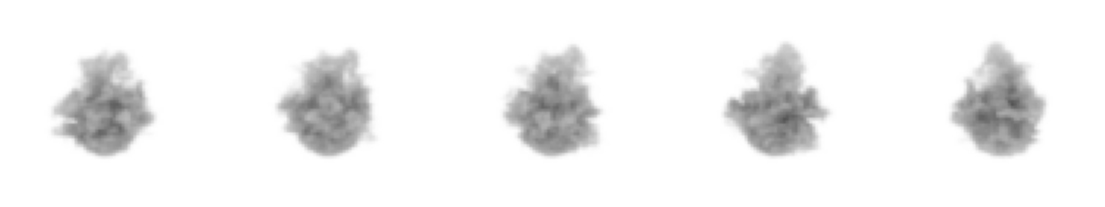

In [3]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]
#ref_images = mi.render(scene_ref, sensor=sensors, spp=ref_spp)
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')
print(ref_images[0].shape)

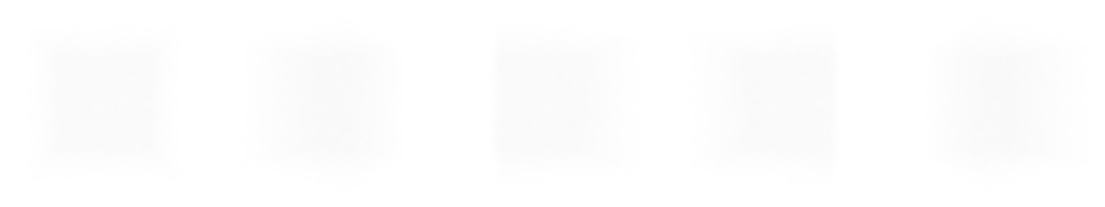

In [4]:
v_res = 16

# Modify the scene dictionary
scene_dict['object'] = {
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, (v_res, v_res, v_res, 1))),
            'to_world': T.translate(-1).scale(2.0)
        },
        'scale': 40.0,
    },
    'bsdf': {'type': 'null'}
}

scene = mi.load_dict(scene_dict)

init_images = [mi.render(scene, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[i].axis('off')

params = mi.traverse(scene)

key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02)
opt[key] = params[key]
params.update(opt);

iteration_count = 40
spp = 8

cus_sensor = mi.load_dict({'type': 'custom_sensor',
                           'id': 'cus',
                           }) #FIXME

# scene is the start scene
ray_loader = Rayloader(scene, cus_sensor, sensors, ref_images, batch_size = 1024, spp = spp)

for it in range(iteration_count):
    
    ref_tensor = ray_loader.next()
    
    img = mi.render(scene, params, sensor=cus_sensor, spp=spp, seed=it)

    # L2 loss function
    loss = dr.mean(dr.sqr(img - ref_tensor))

    # Backpropagate gradients
    dr.backward(loss)

    # Take a gradient step
    opt.step()

    # Clamp the optimized density values. Since we used the `scale` parameter
    # when instantiating the volume, we are in fact optimizing extinction
    # in a range from [1e-6 * scale, scale].
    opt[key] = dr.clamp(opt[key], 1e-6, 1.0)

    # Propagate changes to the scene
    params.update(opt)
    print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

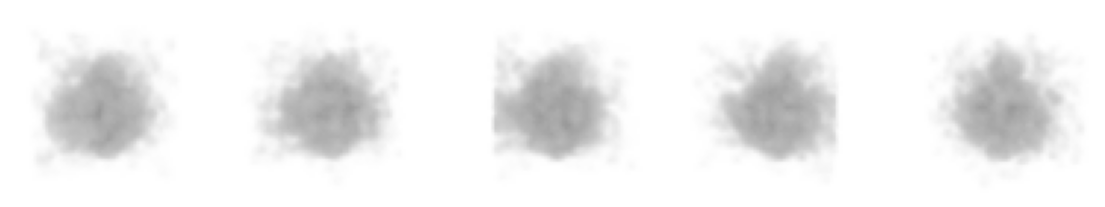

In [5]:
intermediate_images = [mi.render(scene, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_images[i]))
    axs[i].axis('off')